In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import cv2
import mtcnn
from keras.models import load_model
sys.path.append('..')
from utils import get_face, l2_normalizer, normalize, save_pickle, plt_show, get_encode

Using TensorFlow backend.


In [2]:
encoder_model = 'data/model/facenet_keras.h5'
people_dir = 'data/people'
encodings_path = 'data/encodings/encodings.pkl'
test_img_path = 'data/test/rp.jpg'
test_res_path = 'data/results/rp.jpg'

recognition_t = 0.3
required_size = (160, 160)
encoding_dict = dict()

### Models

In [3]:
face_detector = mtcnn.MTCNN()
face_encoder = load_model(encoder_model)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
face_encoder.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [5]:
# get encode


### Prepare

In [6]:
for person_name in os.listdir(people_dir):
    person_dir = os.path.join(people_dir, person_name)
    encodes = []
    for img_name in os.listdir(person_dir):
        img_path = os.path.join(person_dir, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_detector.detect_faces(img_rgb)
        if results:
            res = max(results, key=lambda b: b['box'][2] * b['box'][3])
            face, _, _ = get_face(img_rgb, res['box'])
            
            face = normalize(face)
            face = cv2.resize(face, required_size)
            encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
            encodes.append(encode)
    if encodes:
        encode = np.sum(encodes, axis=0)
        encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
        encoding_dict[person_name] = encode        

In [7]:
# print keys, values
for key, val in encoding_dict.items():
    print(key, val.shape)

ritesh (128,)


#### pickle

In [8]:
save_pickle(encodings_path, encoding_dict)

### Recognizer

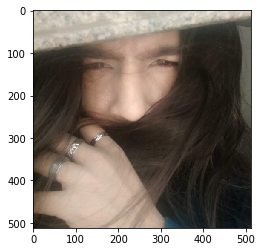

In [9]:
img = cv2.imread(test_img_path)
plt_show(img)

In [10]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = face_detector.detect_faces(img_rgb)
for res in results:
    face, pt_1, pt_2 = get_face(img_rgb, res['box'])
    encode = get_encode(face_encoder, face, required_size)
    encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
    
    name = 'unknown'
    distance = float("inf")
    
    for db_name, db_encode in encoding_dict.items():
        dist = cosine(db_encode, encode)
        if dist < recognition_t and dist < distance:
            name = db_name
            distance = dist
    if name == 'unknown':
        cv2.rectangle(img, pt_1, pt_2, (0,0, 255),1)
        cv2.putText(img,name, pt_1,cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 1)
    else:
        cv2.rectangle(img, pt_1, pt_2, (0, 255, 0),1)
        cv2.putText(img,name + f"__{distance:.2f}", pt_1 ,cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1)    

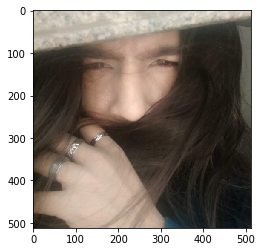

True

In [11]:
plt_show(img)
cv2.imwrite(test_res_path,img)